# Welcome to NLP in 3 weeks

This course is about the power and diversity of NLP methods. We will start with what NLP was in the past and progress to state of the art Transformer models. Through this journey we will discuss how and why methods work!

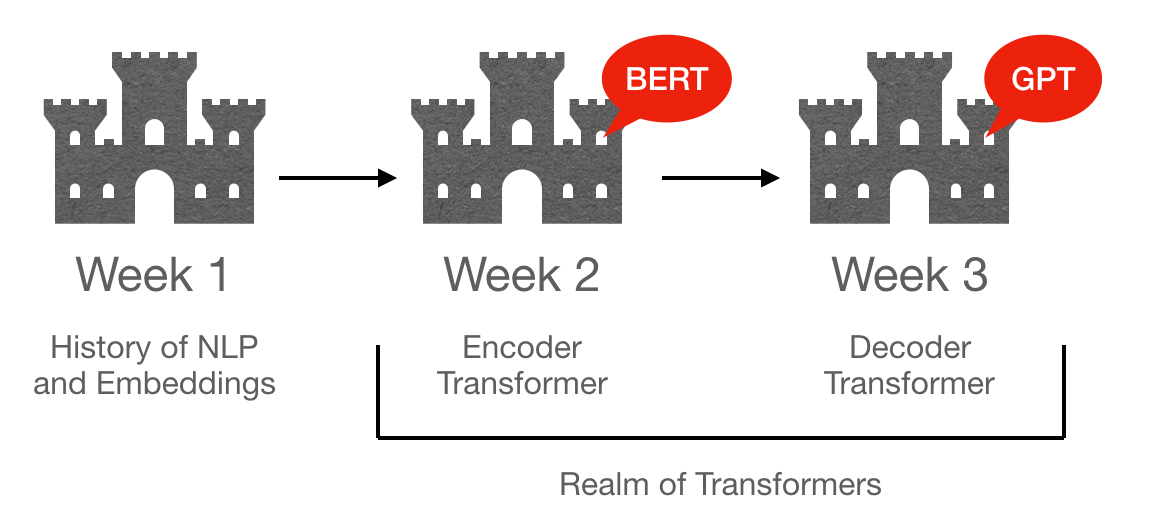

In [ ]:
# Setup
# This cell installs all the dependencies used in this week - imports happen as we go
%%capture
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('word2vec_sample')
!pip install datasets

# Defining NLP

## What is NLP?

*Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data. The goal is a computer capable of **understanding** the contents of documents, including the contextual nuances of the language within them. The technology can then accurately extract information and insights contained in the documents as well as categorize and organize the documents themselves.*

A great summary from [Wikipedia](https://en.wikipedia.org/w/index.php?title=Natural_language_processing&oldid=1122895538)

## What is a natural language?

It is a language that has been evolving naturally as a mean of communicaton between humans.


---

### A few problems to ponder about

*   Every human speaks a little bit different
*   Sometimes we have missunderstandings - even if we use the exact same words, we might describe something different
*   Our Vocabulary evolves over time
*   Sometimes we mean the same using, but are using different words, expressions and or even languages
*   Per above's defintion: is ChatGPT NLP?

## How we thought we can teach computers language

### Symbolic NLP

Formulize all languages as a set of rules (Grammar) and try to create a computational graph from these rules and relevant objects (words / entities).



*   ❌ It is very hard to come up with rules for every person and situtation.
*   ❌ Changes to langugae mean changes to the rules.


### Statistical NLP

Language is conditioned by its wider context (audience / corpus). Instead of fixed rules we try to extract rules from statistical distributions and relationships in that limited context.

*   ✅ Changes over time do not have to be incorporated manually
*   ❌ Deciding which dsitributions are of importance remains a manual task
*   ❌ Still has a hard time conceptualizing dual meanings of words and or expressions

### Neural NLP

All features of a language (grammar, words, semantics) are extracted from the used corpus in an automatic fashion. High-paramterized neural networks can operate on a semantic representation of language to yield the desired output.


*   This is where we are now and if there are any drawbacks, they are...
*   ... that we need a lot of ressources for these neural network models.



# Teaching a computer natural language

Luckily, representing text is already a solved problem. In most programming languages there is a powerful "String" implementation and Unicode standardises even the representation of Emoji 🦄!

[Every Emoji by Codepoint](https://emojipedia.org/emoji/)

In [ ]:
print('\U0001f4af')

In [ ]:
print('\u2764\ufe0f')

But characters are probably not what language is actually about - at least in English!

## The  Twitter Sentiment Analysis Dataset

To load individual words with semantic meaning or any value at all we need a datastructure that allows us to see words as a unite compared to an array of characters...


In the following section we want to use methods from symbolic and statistical NLP to make predictions on texts. To be more precise we want to take a look at the [Twitter Sentiment Analysis](https://huggingface.co/datasets/carblacac/twitter-sentiment-analysis) collected by University of Michigan and a Kaggle Twitter Sentiment Corpus by Niek Sanders. This dataset is a scrape of Twitter and tweets were labeled as positive (1) or  negative (0).

For this mini project we will make use of the [nltk Python library](https://www.nltk.org) that implements many ideas from symbolic and statistical NLP.

There is also the [spaCy Python library](https://spacy.io/) which has even more functionality, but tends to be slower.

In [ ]:
# Let's import nltk and pandas
# We actually already imported nltk before in the setup cell and downloaded a bunch of
# dependencies.

import pandas as pd
import nltk

In [ ]:
# Download the dataset and create a Pandas Dataframe
%%capture
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import numpy as np

dataset = load_dataset("carblacac/twitter-sentiment-analysis", "None")
# Stratified Sample of Dataset
datapoints = 10000

X_train, _, y_train, _ = train_test_split(dataset["validation"]["text"], dataset["validation"]["feeling"],
                                                    train_size=datapoints, random_state=0,
                                                    stratify=dataset["validation"]["feeling"])

df = pd.DataFrame({"text": X_train, "positive": y_train})
df["positive"] = df["positive"].astype("bool")

# We save some memory by deallocating the downloaded dataset
dataset = None

In [ ]:
# Let's peek into the dataset
df

In [ ]:
# Extract a single observation
sample =  df.sample(1, random_state=34)
text = sample["text"].iat[0].split(".")
positive = sample["positive"].iat[0]


for line in text:
    print(line)

print(f"Positive Feeling? - {positive}")

## Symbolic NLP - Explorartory Data Analysis
Just how complicated are words?

First let's make a list of all the words!

In [ ]:
# First intuition: Let's count word occourences
from collections import defaultdict, Counter
from tqdm import tqdm

# We use Python's build in Counter object here
word_counts = Counter()

for row in tqdm(df.iterrows(), total=len(df)):
    text = row[1]

    # Pandas's built in split() method of a string column splits on whitespace characters
    for word in text.str.split()[0]:
        word_counts[word] += 1

len(word_counts)

In [ ]:
# Peek at the most common 25 words
word_counts.most_common(25)

In [ ]:
# Peek at 10 of the words that only appeared once
# Note the words ending in fullstops or words connected by punctuation.
word_counts.most_common()[:-len(word_counts)-1:-1][10:20]

In [ ]:
# NLTK has a split function that uses rules - e.g. implements symbolic NLP
from nltk import word_tokenize

In [ ]:
word_counts = Counter()

for row in tqdm(df.iterrows(), total=len(df)):
    text = row[1].iat[0]
    for word in word_tokenize(text):
        word_counts[word] += 1

len(word_counts)

In [ ]:
# Using NLTK's word_tokenize we could get rid of punctuation
word_counts.most_common()[:-len(word_counts)-1:-1][10:20]

At this point of practicing symbolic NLP you might get an idea how much manual labor is necessary to come up with all the rules needed.

One thing we notice with the English language is that most words are not cased. E.g. upper and lower case has hardly any meaning and instead is more of a decorative feature.

What about your language?

In German the meaning of lowercase and uppercase words is more important when words are isolated. In Chinese there is no whitespace nor upper and lower case at all...

In [ ]:
# Let's turn everything lowercase
word_counts = Counter()

for row in tqdm(df.iterrows(), total=len(df)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()
        word_counts[word_lowercase] += 1

len(word_counts)

In [ ]:
word_counts.most_common()[:-len(word_counts)-1:-1][10:20]

### A hint of statistical NLP
The most common words are probably less useful for predicting whether somebody wrote a positive or negative tweet - luckily, there are handy tools to remove them provided by NLTK.

In [ ]:
from nltk.corpus import stopwords

stopwords_en = stopwords.words('english')

word_counts = Counter()

for row in tqdm(df.iterrows(), total=len(df)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            word_counts[word_lowercase] += 1

len(word_counts)

In [ ]:
word_counts.most_common()[:-len(word_counts)-1:-1][10:20]

In [ ]:
word_counts.most_common(10)

Oh no, hidden among our most common words are isolated special characters...

In [ ]:
from string import punctuation

# We can add Python's native list of punctuation characters to our stopwords using a set union
stopwords_en = set(stopwords_en).union(set(punctuation))

word_counts = Counter()

for row in tqdm(df.iterrows(), total=len(df)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            word_counts[word_lowercase] += 1

len(word_counts)

In [ ]:
word_counts.most_common(10)

### Stemming and Lemmatization

There are two more operations we could do to "simplify" our vocabulary...



*   **Stemming**: Remove all suffixes, declianations and conjugations from a word and only leave the stem
    *   meeting --> meet
    *   meets --> meet
    *   meet --> meet

*   **Lemmatization**: First identify the part of speech of a word, than remove inflictions
    * meeting (Verb) --> meet
    * meeting (Noun) --> Meeting

How do we know the the part of speech of a word? Symbolic NLP - just like in school 🙈


In [ ]:
# This cell uses Stemming
from nltk.stem import PorterStemmer

porter = PorterStemmer()

word_counts = Counter()

for row in tqdm(df.iterrows(), total=len(df)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            stemmed_word = porter.stem(word_lowercase)
            word_counts[stemmed_word] += 1

len(word_counts)

In [ ]:
# Let's see stemming at work in detail
print("meeting --> ", porter.stem("meeting"))
print("meets --> ", porter.stem("meets"))
print("the meeting --> ", porter.stem("the meeting"))

In [ ]:
word_counts.most_common(10)

In [ ]:
# And this cell uses Lemmatization

from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

word_counts = Counter()

for row in tqdm(df.iterrows(), total=len(df)):
    text = row[1].iat[0]

    for word, tag in pos_tag(word_tokenize(text)):
        word_lemmatized = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))

        if word_lemmatized not in stopwords_en:
            word_counts[word_lemmatized] += 1

len(word_counts)

In [ ]:
word_counts.most_common(10)

In [ ]:
# Let's see lemmatization in detail
text = """Deep in the forest, the council is meeting for the first time since the 'event'.\n
          Right when the meeting commences, a long howl disrupts and snaps them to immediate attention and the mages ..."""

text_lemmatized = ""
for word, tag in pos_tag(word_tokenize(text)):
    word_lemmatized = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
    text_lemmatized += f"{word} ({tag}, {word_lemmatized}) "

print(text_lemmatized)

If you want to learn more about nltk's pos tagger - here is an interesting [Blog Post by the author](https://explosion.ai/blog/part-of-speech-pos-tagger-in-python).

## Statistical NLP - Training Machine Learning models on texts

This is what you came for, right, maybe?

Let us define a very simple base model - we want to model the relationship between the number of times "love" appeared in a text and whether the tweet expressed a positive sentiment.

In [ ]:
X = []
y = []

for row in tqdm(df.iterrows(), total=len(df)):
    text = row[1].iat[0]
    x = 0

    for word, tag in pos_tag(word_tokenize(text)):
        word_lemmatized = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))

        if word_lemmatized == "love":
            x += 1

    X.append(x)
    y.append(row[1].iat[1])

In [ ]:
# Let's define a meaningful train-test-split
from sklearn.model_selection import train_test_split
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(np.array(X).reshape(-1, 1), np.array(y),
                                                    test_size=0.15, random_state=0,
                                                    stratify=y)

len(y_train), len(y_test)

In [ ]:
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression()
clf.fit(X=X_train, y=y_train)

In [ ]:
clf.score(X=X_test, y=y_test) # 😑

### Simple Word Vectors

This model is obviously useless - we threw away most of the information available!

We have to consider other words, too. The simplest approach is using a bag-of-words approach. E. g. for each text we use the counts of each word, but with no respect to their position in the sentence. Just like a word cloud!

Since we have to introduce one predictor per word to our model we basically treat them as categorical data. Instead of counting the words we might also just one hot encode them.

The process of converting words to vectors is called word emebdding and this is the most simple version of it.

In [ ]:
# Let's first define a meaningful train-test-split
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df["text"],
                                                    df["positive"],
                                                    test_size=0.15, random_state=0,
                                                    stratify=df["positive"])

len(y_train), len(y_test)

In [ ]:
# From EDA above we can formulate this function that extracts all the words we care about
# from a given text
def preprocessing_function(text):
    words = []

    for word, tag in pos_tag(word_tokenize(text)):
        word_lemmatized = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))

        if word_lemmatized not in stopwords_en and not word_lemmatized.isdigit():
            words.append(word_lemmatized)

    return words

In [ ]:
# Sklearn has a CountVectorizer object that allows us to pass an "analyzer"
# The "analyzer" gets the text passed and returns a list of things to count
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer=preprocessing_function)

In [ ]:
# We train the CountVectorizer on the train set and transform both datsets
X_train_vectorized = count_vectorizer.fit_transform(X_train)
X_test_vectorized = count_vectorizer.transform(X_test)

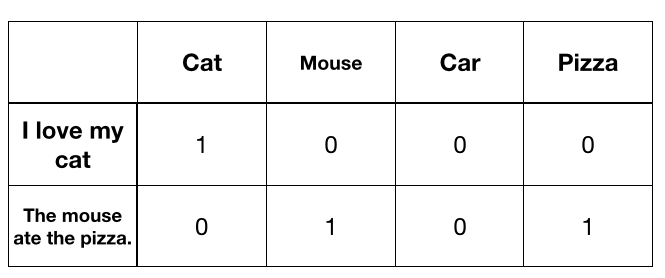

In [ ]:
# Naturally, the resulting vector is pretty sparse
X_train_vectorized.toarray()[0]

In [ ]:
count_vectorizer.vocabulary_

In [ ]:
# Let's inspect just the "love" column
idx_of_love = count_vectorizer.vocabulary_["love"]
X_train_vectorized.toarray()[:, idx_of_love]

### Statistical Learning

Let's see of this count vector is enough to do sentiment analysis

In [ ]:
# We can define our own test function
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test(clf):
  clf.fit(X_train_vectorized.toarray(), y_train)
  y_pred = clf.predict(X_test_vectorized.toarray())

  print(f"accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}")

  return ConfusionMatrixDisplay.from_estimator(
      clf, X_test_vectorized.toarray(), y_test,  xticks_rotation="vertical"
  )

#### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
test(clf)

#### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=42)
test(clf)

#### Logistic Regression

In [ ]:
# Logistic Regression has already been imported
clf = LogisticRegression()
test(clf)

## Neural NLP

## Interludium - Firth

This model did okaish and we could continue trying more complex models like Gradient Boosting, but eventually we have to accept that we are currently ignoring the context of words used entierly.

What if we could add a hint to our word vectors where a word is used or in what context? But how would we express such an information and how would you calculate it?


---


*You shall know a word by the company it keeps* (J.R. Firth 1957)

The words meaning is defined by the words in its context.

## Word 2 Vec

In 2013 researchers at Google published an idea that changed our understanding of words and directly uses the idea proposed above: The place in vector space where a word should be positioned is defined by the words typically surrounding it. Instead of a single dimension per word as in one-hot-encoding there are a shared dimensions for all words and their position can be used to infer their meaning.

Such a space would be hard to craft by hand and instead is learned from a corpus. Let's see how...

In [ ]:
import torch

$likelihood = L(θ) = \prod_\limits{t=1}^{T}\prod\limits_{\substack{-m\leq j \leq m \\ j \neq 0}}P(w_{t+j}\mid
w_t;θ)$

In [ ]:
corpus = ["hello", "world", "this", "is", "a", "signal", "from", "outer", "space"]
T = len(corpus)
T

In [ ]:
m = 2
for t in range(T):

  window = []
  for j in range(-m, m+1):
    if j == 0:
      continue
    if t + j < 0 or t + j >= len(corpus):
      continue
    window.append(corpus[t+j])
  print(corpus[t] + ": " +" ".join(window))


### How do we calculate the $P(w_{t+j}\mid
w_t;θ)$?


$v_w$ vector for word $w$ if it is in the center.

$u_w$ vector for word $w$ if it is in the context window.


$softmax = P(w_{O} \mid w_{I}) = \frac{\exp (u_{o}^{T} v_{i}) }{∑\limits_{w=1}^W \exp(u_w^Tv_{i})} $

In [ ]:
unique_corpus = list(set(corpus))
W = len(unique_corpus)
W

In [ ]:
v = [torch.rand(5) for _ in range(W)]
u = [torch.rand(5) for _ in range(W)]

In [ ]:
def prob(center, context):
    factor = torch.exp(torch.dot(u[context], v[center]))
    normalization_constant = 0

    for w in range(W):
        normalization_constant += torch.dot(u[w], v[center])
    return factor / normalization_constant

[Click here for a very detailed walk through word2vec](https://colab.research.google.com/drive/1_65iXT8aq_yKh6b0BkoRStPYEIMIueRP?usp=sharing
)

## The intuition behind word2vec

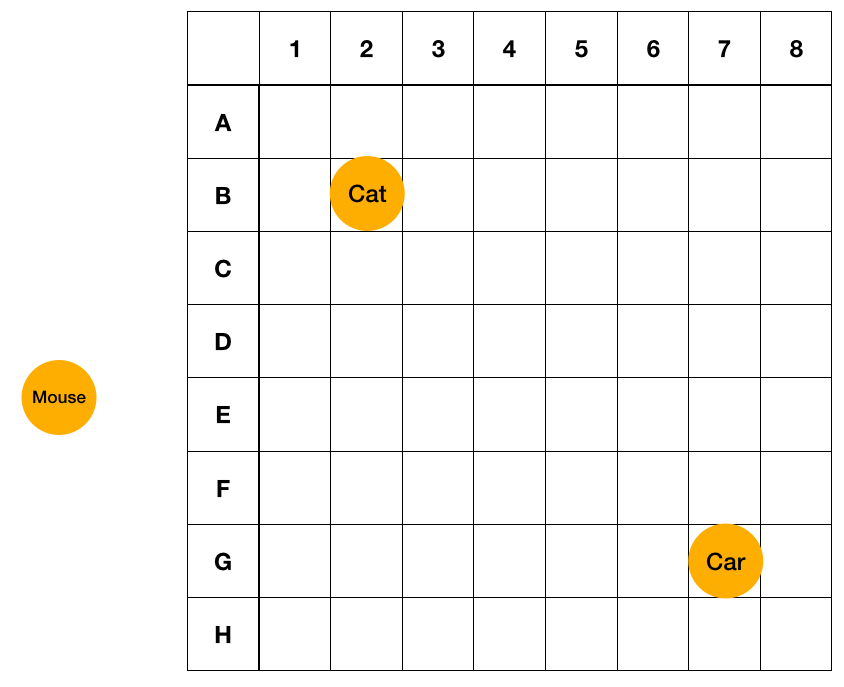

## Using a pretrained Word2Vec model

In [ ]:
# We can download and use a small Word2Vec model with NLTK
# WARNING EXECUTING THIS CELL might take up to 8 minutes
from nltk.data import find
import gensim
import gensim.downloader

model = gensim.downloader.load('glove-twitter-200')

In [ ]:
# Let's see the representation of "love"
model["love"]

In [ ]:
# One vector has 200 dimensions
model["love"].shape

In [ ]:
# Any dimensionality reduction is fine to reduce this R^200 to R^2
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

In [ ]:
# Let's create some embeddings
import numpy as np

queen_embedded = model["queen"]
king_embedded = model["king"]
cat_embedded = model["cat"]
dog_embedded = model["dog"]
tree_embedded = model["tree"]
monkey_embedded = model["monkey"]

sub_space = np.vstack(
    [queen_embedded, king_embedded, cat_embedded,
     dog_embedded, tree_embedded, monkey_embedded])

In [ ]:
# One 200 dimension vector per word ...
sub_space.shape

In [ ]:
# ... turns into one 2 dimensional vector per word
redcued_sub_space = pca.fit_transform(sub_space)
redcued_sub_space.shape

In [ ]:
# A scatter plot is the right choice to visualise the embedding space
import seaborn as sns


sns.set(style='white', context='notebook', rc={'figure.figsize':(6, 6), 'figure.dpi':111})

sns.scatterplot(x=redcued_sub_space[:, 0], y=redcued_sub_space[:, 1], s=150,
                style=["queen", "king", "cat", "dog", "tree", "monkey"],
                hue=["queen", "king", "cat", "dog", "tree", "monkey"])

In [ ]:
# We can reuse the preprocessing_function from above and additionally run each word through word2vec
import numpy as np


def embed_in_word_2_vec(text):
    prepocessed_words = preprocessing_function(text)

    representations = []
    for word in prepocessed_words:
        if word in model:
            representations.append(model[word])

    if representations:
        # Why do we mean here?
        return np.vstack(representations).mean(axis=0)
    else:
        return np.zeros(200)


embed_in_word_2_vec("I love pizza!").shape

In [ ]:
X_train_embedded = list(map(embed_in_word_2_vec, X_train.tolist()))
X_test_embedded = list(map(embed_in_word_2_vec, X_test.tolist()))

In [ ]:
X_train_embedded_np = np.concatenate([np.expand_dims(v, axis=0) for v in X_train_embedded], axis=0)
X_test_embedded_np = np.concatenate([np.expand_dims(v, axis=0) for v in X_test_embedded], axis=0)

In [ ]:
# Let's try the most simple neural network we have - logitstic regression
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression()
clf.fit(X=X_train_embedded_np, y=y_train)

In [ ]:
clf.score(X=X_test_embedded_np, y=y_test) # 🥳

## Things to ponder about...

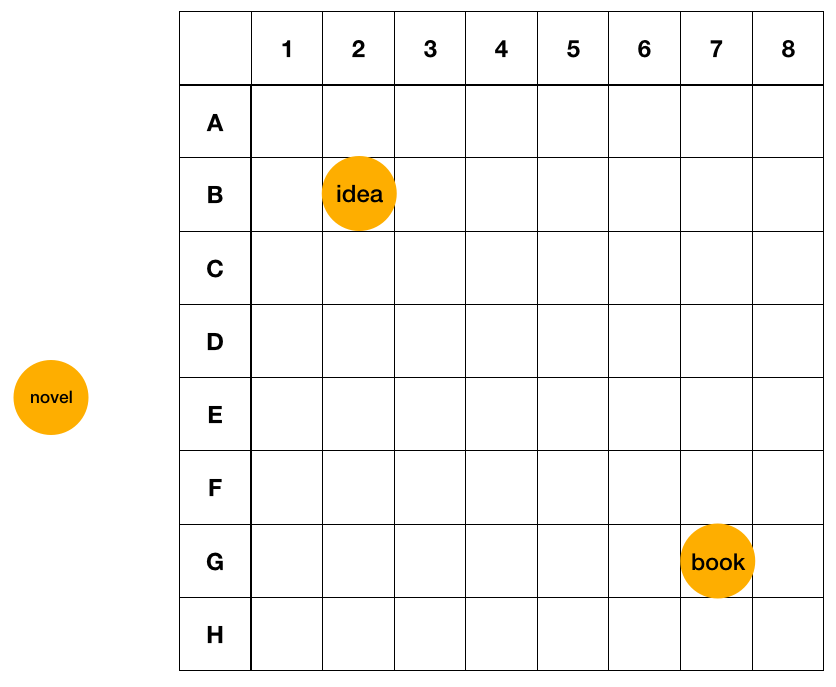